In [8]:
import psycopg2
import pandas as pd
from sqlalchemy import create_engine
# from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
# analyzer = SentimentIntensityAnalyzer()
import numpy as np
import pandas_datareader as web
import math
import datetime as dt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')

Using TensorFlow backend.


# Retrieve the data from rds database

* obtain the Nasdaq data, oil price data and Tweet news data.

In [9]:
conn = psycopg2.connect(
    database="example",
    user="postgres",
    password="password",
    host="database-2.cmuyi10lpj9v.us-west-1.rds.amazonaws.com",
    port='5432'
)
cur = conn.cursor()
cur.execute("""SELECT * FROM sentiments""")
rows = cur.fetchall()
sentiments = pd.DataFrame(rows)

cur.execute("""SELECT * FROM nasdaq""")
rows = cur.fetchall()
nasdaqDF = pd.DataFrame(rows)

cur.execute("""SELECT * FROM eta""")
rows = cur.fetchall()
etaDF = pd.DataFrame(rows)

conn.close()

In [10]:
# rename the for the oil table coulmns 
etaDF.rename(columns= { 0: 'id',1: 'date',2: 'price', 3: 'diff', 4: 'label'}, inplace= True) 
etaDF.head(3)

,id,date,price,diff,label
0,1,2006-06-12,70.28,-1.34,0
1,2,2006-06-13,68.48,-1.80,0
2,3,2006-06-14,69.12,0.64,1


In [11]:
# rename the for the tweet news table coulmns 
sentiments.rename (columns= { 0: 'id',1: 'date',2: 'Compound', 3: 'Positive', 4: 'Negative',5: 'Neutral'}, inplace= True) 
sentiments

,id,date,Compound,Positive,Negative,Neutral
0,0,2010-01-02,-0.201375,0.049500,0.752375,0.198125
1,1,2010-01-03,-0.001012,0.063750,0.865750,0.070500
2,2,2010-01-04,0.098568,0.094909,0.871636,0.033500
3,3,2010-01-05,0.010268,0.056636,0.912818,0.030545
4,4,2010-01-06,-0.025283,0.056500,0.890125,0.053375
...,...,...,...,...,...,...
3813,3813,2020-11-10,0.057316,0.072629,0.883677,0.043694
3814,3814,2020-11-11,0.049574,0.063011,0.903977,0.033011
3815,3815,2020-11-12,0.060377,0.076276,0.876759,0.046989
3816,3816,2020-11-13,0.030476,0.059390,0.873232,0.067390


In [12]:
# rename the for the Nasdaq table coulmns 
nasdaqDF = nasdaqDF.rename(columns={4:'label',1:'date'})
nasdaqDF.drop_duplicates(['date'], keep='last')
nasdaqDF

,0,date,2,3,label
0,1,2006-05-30,2164.74,-45.63,0
1,2,2006-05-31,2178.88,14.14,1
2,3,2006-06-01,2219.86,40.98,1
3,4,2006-06-02,2219.41,-0.45,0
4,5,2006-06-05,2169.62,-49.79,0
...,...,...,...,...,...
3637,2051,2014-07-14,4440.42,24.93,1
3638,2052,2014-07-15,4416.39,-24.03,0
3639,2053,2014-07-16,4425.97,9.58,1
3640,2054,2014-07-17,4363.45,-62.52,0


# Merge data 

* merge the Nasdaq and tweetnews table.

In [13]:
nasdaq_newsDF = pd.merge(nasdaqDF, sentiments, how="inner", on = ["date","date"])
merged_df = nasdaq_newsDF.dropna()
merged_df

,0,date,2,3,label,id,Compound,Positive,Negative,Neutral
0,2056,2014-07-21,4424.70,-7.45,0,1534,-0.140688,0.051231,0.827769,0.121000
1,2057,2014-07-22,4456.02,31.32,1,1535,-0.093103,0.059043,0.847043,0.093913
2,2058,2014-07-23,4473.70,17.68,1,1536,-0.060000,0.060761,0.846690,0.092549
3,2059,2014-07-24,4472.11,-1.59,0,1537,-0.162829,0.043673,0.828898,0.127449
4,2060,2014-07-25,4449.56,-22.55,0,1538,-0.012870,0.065132,0.864943,0.069943
...,...,...,...,...,...,...,...,...,...,...
2686,2051,2014-07-14,4440.42,24.93,1,1527,0.045877,0.071585,0.873569,0.054846
2687,2052,2014-07-15,4416.39,-24.03,0,1528,0.030637,0.070402,0.865439,0.064146
2688,2053,2014-07-16,4425.97,9.58,1,1529,-0.055856,0.055137,0.837192,0.107671
2689,2054,2014-07-17,4363.45,-62.52,0,1530,0.015665,0.064833,0.880222,0.054944


In [14]:
merged_df = merged_df.loc[:, ['label','date','Compound','Positive','Negative','Neutral']]
merged_df

,label,date,Compound,Positive,Negative,Neutral
0,0,2014-07-21,-0.140688,0.051231,0.827769,0.121000
1,1,2014-07-22,-0.093103,0.059043,0.847043,0.093913
2,1,2014-07-23,-0.060000,0.060761,0.846690,0.092549
3,0,2014-07-24,-0.162829,0.043673,0.828898,0.127449
4,0,2014-07-25,-0.012870,0.065132,0.864943,0.069943
...,...,...,...,...,...,...
2686,1,2014-07-14,0.045877,0.071585,0.873569,0.054846
2687,0,2014-07-15,0.030637,0.070402,0.865439,0.064146
2688,1,2014-07-16,-0.055856,0.055137,0.837192,0.107671
2689,0,2014-07-17,0.015665,0.064833,0.880222,0.054944


In [118]:
merged_df.dtypes

label                int64
date        datetime64[ns]
Compound           float64
Positive           float64
Negative           float64
Neutral            float64
year                 int64
month                int64
day                  int64
dtype: object

In [119]:
merged_df['date']= pd.to_datetime(merged_df['date'],format='%Y-%m')
merged_df['year']= merged_df['date'].dt.year
merged_df['month']= merged_df['date'].dt.month
merged_df['day']= merged_df['date'].dt.day
merged_df

,label,date,Compound,Positive,Negative,Neutral,year,month,day
0,0,2014-07-21,-0.140688,0.051231,0.827769,0.121000,2014,7,21
1,1,2014-07-22,-0.093103,0.059043,0.847043,0.093913,2014,7,22
2,1,2014-07-23,-0.060000,0.060761,0.846690,0.092549,2014,7,23
3,0,2014-07-24,-0.162829,0.043673,0.828898,0.127449,2014,7,24
4,0,2014-07-25,-0.012870,0.065132,0.864943,0.069943,2014,7,25
...,...,...,...,...,...,...,...,...,...
2686,1,2014-07-14,0.045877,0.071585,0.873569,0.054846,2014,7,14
2687,0,2014-07-15,0.030637,0.070402,0.865439,0.064146,2014,7,15
2688,1,2014-07-16,-0.055856,0.055137,0.837192,0.107671,2014,7,16
2689,0,2014-07-17,0.015665,0.064833,0.880222,0.054944,2014,7,17


In [122]:
group= merged_df.groupby(["year"])
meanvalue = group["Compound"].mean()
meanvalue

year
2010    0.027199
2011   -0.011781
2012    0.027782
2013    0.020071
2014   -0.004744
2015   -0.014005
2016   -0.016659
2017   -0.007235
2018   -0.000327
2019   -0.001409
2020   -0.001055
Name: Compound, dtype: float64

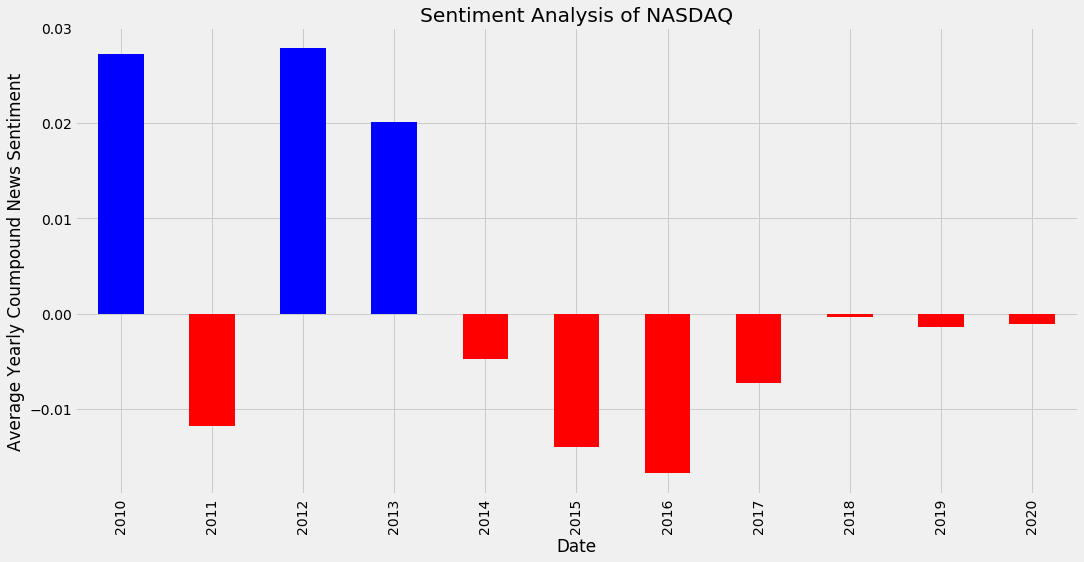

In [141]:
plt.figure(figsize=(16,8))
plt.title("Sentiment Analysis of NASDAQ")
meanvalue.plot(kind='bar', color=(meanvalue>0).map({True:'b', False: 'r'}))
plt.xlabel("Date")
plt.ylabel("Average Yearly Coumpound News Sentiment")
plt.show()

In [142]:
# Create regression data
nasdaq_newsDF
# Rename cloumn '3 as Daily Returns'
nasdaq_new=nasdaq_newsDF.rename(columns={3: "Daily Returns"})
nasdaq_new

,0,date,2,Daily Returns,label,id,Compound,Positive,Negative,Neutral
0,2056,2014-07-21,4424.70,-7.45,0,1534,-0.140688,0.051231,0.827769,0.121000
1,2057,2014-07-22,4456.02,31.32,1,1535,-0.093103,0.059043,0.847043,0.093913
2,2058,2014-07-23,4473.70,17.68,1,1536,-0.060000,0.060761,0.846690,0.092549
3,2059,2014-07-24,4472.11,-1.59,0,1537,-0.162829,0.043673,0.828898,0.127449
4,2060,2014-07-25,4449.56,-22.55,0,1538,-0.012870,0.065132,0.864943,0.069943
...,...,...,...,...,...,...,...,...,...,...
2686,2051,2014-07-14,4440.42,24.93,1,1527,0.045877,0.071585,0.873569,0.054846
2687,2052,2014-07-15,4416.39,-24.03,0,1528,0.030637,0.070402,0.865439,0.064146
2688,2053,2014-07-16,4425.97,9.58,1,1529,-0.055856,0.055137,0.837192,0.107671
2689,2054,2014-07-17,4363.45,-62.52,0,1530,0.015665,0.064833,0.880222,0.054944


In [143]:
clean_df = nasdaq_new[['Daily Returns', "Compound"]]
clean_df

,Daily Returns,Compound
0,-7.45,-0.140688
1,31.32,-0.093103
2,17.68,-0.060000
3,-1.59,-0.162829
4,-22.55,-0.012870
...,...,...
2686,24.93,0.045877
2687,-24.03,0.030637
2688,9.58,-0.055856
2689,-62.52,0.015665


In [176]:
# Assign the data to X and y
# Note: Sklearn requires a two-dimensional array of values
X = clean_df["Daily Returns"].values.reshape(-1, 1)
y = clean_df["Compound"].values.reshape(-1, 1)
print("Shape: ", X.shape, y.shape)

Shape:  (2691, 1) (2691, 1)


In [177]:
import scipy.stats as st

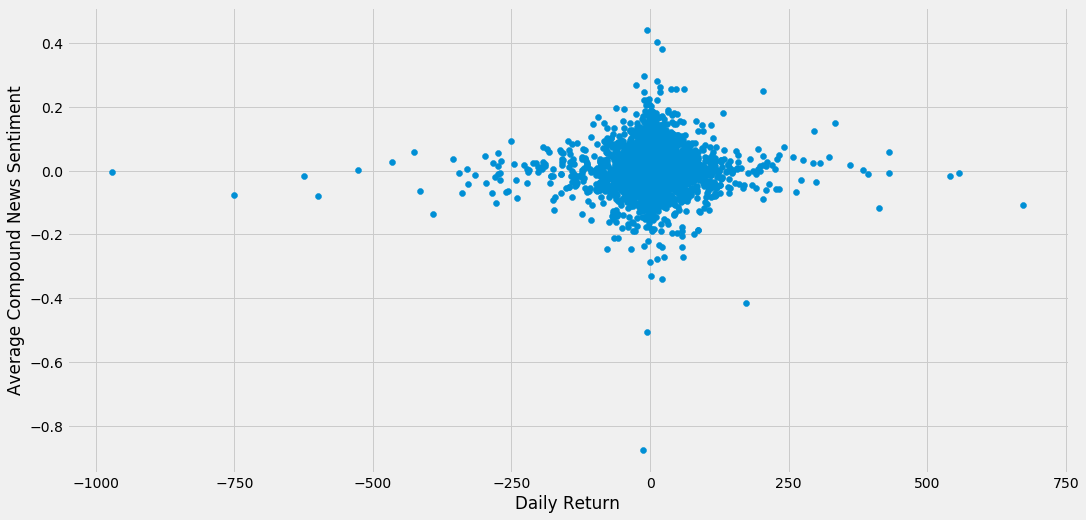

In [179]:
# Plot the data to see if a linear trend exists
plt.figure(figsize=(16,8))
plt.scatter(X, y)
plt.xlabel("Daily Return")
plt.ylabel("Average Compound News Sentiment")
plt.show()

# Pre-processing

* Preprocess the dataset prior to fitting the model.
* Perform feature selection and remove unnecessary features.
* Use `MinMaxScaler` to scale the numerical data.
* Separate the data into training and testing data.

In [22]:
y = nasdaq_newsDF["label"]
X = nasdaq_newsDF.loc[:, ['Compound','Positive','Negative','Neutral']]
print(X.shape, y.shape)

(2691, 4) (2691,)


In [23]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

In [130]:
# Create model
model = LinearRegression()
# Fit the model to the training data. 

model.fit(X_train, y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [131]:
LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

In [132]:
# Calculate the mean_squared_error and the r-squared value
# for the testing data

from sklearn.metrics import mean_squared_error, r2_score

In [133]:
# Use our model to make predictions
predicted = model.predict(X_test)

# Score the predictions with mse and r2
mse = mean_squared_error(y_test, predicted)
r2 = r2_score(y_test, predicted)

print(f"Mean Squared Error (MSE): {mse}")
print(f"R-squared (R2 ): {r2}")

Mean Squared Error (MSE): 0.005056210503495983
R-squared (R2 ): 0.00045338644738290856


In [134]:
# Call the `score` method on the model to show the r2 score
model.score(X_test, y_test)

0.00045338644738290856

In [72]:
from sklearn.model_selection import train_test_split

In [73]:
nasdaq_new
nasdaq_df=nasdaq_new.rename(columns={2:"Daily Index", 3: "Daily Returns"})
nasdaq_df

,0,date,Daily Index,Daily Returns,label,id,Compound,Positive,Negative,Neutral
0,2056,2014-07-21,4424.70,-7.45,0,1534,-0.140688,0.051231,0.827769,0.121000
1,2057,2014-07-22,4456.02,31.32,1,1535,-0.093103,0.059043,0.847043,0.093913
2,2058,2014-07-23,4473.70,17.68,1,1536,-0.060000,0.060761,0.846690,0.092549
3,2059,2014-07-24,4472.11,-1.59,0,1537,-0.162829,0.043673,0.828898,0.127449
4,2060,2014-07-25,4449.56,-22.55,0,1538,-0.012870,0.065132,0.864943,0.069943
...,...,...,...,...,...,...,...,...,...,...
2686,2051,2014-07-14,4440.42,24.93,1,1527,0.045877,0.071585,0.873569,0.054846
2687,2052,2014-07-15,4416.39,-24.03,0,1528,0.030637,0.070402,0.865439,0.064146
2688,2053,2014-07-16,4425.97,9.58,1,1529,-0.055856,0.055137,0.837192,0.107671
2689,2054,2014-07-17,4363.45,-62.52,0,1530,0.015665,0.064833,0.880222,0.054944


In [74]:
keep_columns = ['Daily Index', 'Daily Returns', 'label','Compound', 'Positive', 'Negative', 'Neutral']
new_df= nasdaq_df[keep_columns]
new_df

,Daily Index,Daily Returns,label,Compound,Positive,Negative,Neutral
0,4424.70,-7.45,0,-0.140688,0.051231,0.827769,0.121000
1,4456.02,31.32,1,-0.093103,0.059043,0.847043,0.093913
2,4473.70,17.68,1,-0.060000,0.060761,0.846690,0.092549
3,4472.11,-1.59,0,-0.162829,0.043673,0.828898,0.127449
4,4449.56,-22.55,0,-0.012870,0.065132,0.864943,0.069943
...,...,...,...,...,...,...,...
2686,4440.42,24.93,1,0.045877,0.071585,0.873569,0.054846
2687,4416.39,-24.03,0,0.030637,0.070402,0.865439,0.064146
2688,4425.97,9.58,1,-0.055856,0.055137,0.837192,0.107671
2689,4363.45,-62.52,0,0.015665,0.064833,0.880222,0.054944


In [75]:
# Create the feature data set
x = np.array(new_df.drop(['label'], 1))

# Create the target dat set
y = np.array(new_df['label'])


In [76]:
from sklearn.metrics import accuracy_score, classification_report
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

In [77]:
# Create feature data set and Split the data into 80% training and 20% testing
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.2, random_state=0)

In [78]:
# Create and train model
model = LinearDiscriminantAnalysis().fit(x_train, y_train)

In [79]:
# Show mdeil predictions
predictions = model.predict(x_test)
predictions

array([1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1,
       1, 1, 0, 1, 0, 0, 1, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 0, 0, 1, 0,
       1, 1, 0, 0, 1, 0, 1, 0, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 0,
       0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1,
       0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0,
       1, 0, 0, 1, 1, 1, 1, 0, 0, 1, 1, 0, 1, 0, 1, 1, 1, 0, 0, 1, 0, 0,
       1, 0, 1, 1, 0, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0,
       0, 1, 1, 0, 1, 0, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1,
       1, 0, 0, 0, 0, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1,
       1, 0, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 0,
       1, 1, 0, 0, 0, 1, 1, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 1, 0, 1, 0, 1,
       1, 1, 1, 0, 1, 0, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 0,
       1, 1, 1, 0, 1, 1, 0, 1, 0, 1, 1, 0, 0, 1, 1,

In [80]:
y_test

array([1, 0, 1, 1, 1, 0, 1, 1, 0, 1, 1, 0, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1,
       1, 1, 0, 1, 0, 0, 0, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 0, 0, 1, 0,
       1, 1, 0, 0, 1, 0, 1, 0, 1, 1, 0, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 0,
       0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 0, 1, 0, 1, 0, 1, 1, 1, 0, 1,
       0, 0, 1, 0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 0, 1, 1, 1, 0, 1, 0, 0,
       0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 1, 0, 1, 0, 1, 0, 0, 1, 0, 0,
       1, 0, 1, 1, 0, 1, 0, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       0, 1, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 0, 0, 1, 0, 1, 1, 0, 1, 0,
       0, 1, 1, 0, 1, 0, 1, 0, 1, 0, 1, 1, 0, 1, 0, 1, 0, 0, 0, 1, 1, 1,
       1, 0, 0, 0, 0, 1, 0, 0, 1, 1, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1,
       1, 0, 1, 0, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0,
       1, 1, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1,
       1, 1, 1, 0, 1, 0, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 0,
       1, 1, 1, 0, 1, 1, 0, 0, 0, 1, 1, 0, 0, 1, 1,

In [81]:
# Show the model metrics
print(classification_report(y_test, predictions))

              precision    recall  f1-score   support

           0       1.00      0.73      0.85       233
           1       0.83      1.00      0.91       306

    accuracy                           0.88       539
   macro avg       0.92      0.87      0.88       539
weighted avg       0.90      0.88      0.88       539



In [84]:

# X_scaler = MinMaxScaler().fit(X_train)
# X_train_scaled = X_scaler.transform(X_train)
# X_test_scaled = X_scaler.transform(X_test)

In [18]:
# Step 1: Label-encode data set
# label_encoder = LabelEncoder()
# label_encoder.fit(y_train)
# encoded_y_train = label_encoder.transform(y_train)
# encoded_y_test = label_encoder.transform(y_test)

# # Step 2: Convert encoded labels to one-hot-encoding
# y_train_categorical = to_categorical(encoded_y_train)
# y_test_categorical = to_categorical(encoded_y_test)

# Train the Support Vector Machine